In [39]:
# Wavefunction generation
from pyscf import mcscf, fci, lib 
from pyscf import gto, scf, tools, dft
from pyscf.dft import numint
import api as pyq 
import matplotlib.pyplot as plt
import importlib
import os
import h5py
import pdb
import pyscf
import numpy as np
from pyscf.scf.hf import dump_scf_summary
print(pyq.__file__)
print(pyscf.__file__)

/Users/ksu/Documents/GitHub/pyqmc/pyqmc/api.py
/usr/local/anaconda3/lib/python3.9/site-packages/pyscf/__init__.py


In [40]:
# Compare VXC from user input and PYSCF

In [56]:
from math import pi
mol = gto.M(atom="H 0. 0. 0.; H 0. 0. 1.2", spin=2, basis=f'ccecpccpvdz', unit='bohr')
mf = scf.UKS(mol)
scf_checkfile = "scf.hdf5"


#User defined XC functional (Slater exchange only)
factor = -3.0/4.0 * (3.0 / pi)**(1.0/3.0)
power = 4.0/3.0
def eval_xc(rho, a=factor, p=power):
    exc = a * rho ** p
    vrho = a * p * rho ** (p-1.0)
    vxc = (vrho, None, None, None)
    fxc = None  # 2nd order functional derivative
    kxc = None  # 3rd order functional derivative
    return exc, vxc, fxc, kxc


def my_eval_xc(a,p):    
    def eval_xc(xc_code, rho, *args, **kwargs):
        exc = a * rho ** p
        vrho = a * p * rho ** (p-1.0)
        vxc = (vrho, None, None, None)
        fxc = None  # 2nd order functional derivative
        kxc = None  # 3rd order functional derivative
        return exc, vxc, fxc, kxc
    return eval_xc
mf = mf.define_xc_(my_eval_xc(factor,power), 'LDA')
mf.kernel()
# mf.kernel(dm, xc='LDA,VWN')

ValueError: shapes (18696,) and (2,18696) not aligned: 18696 (dim 0) != 2 (dim 0)

In [42]:
mf.scf_summary

{'e1': -2.636210021867354,
 'coul': 1.369865813598822,
 'exc': -0.6843546298633597,
 'nuc': 0.8333333333333334}

In [43]:
#Grid
size = 1000
pos = np.linspace([0.,0.,0.],[0.,0., 1.2], size)
r = np.linalg.norm(pos, axis=1)

In [44]:
#Overlaps
aox = dft.numint.eval_ao(mol, pos, deriv=2)
ao0 = aox[0]
ao1 = aox[1:4]
ao2 = aox[4:4]
orb_coeffs = mf.mo_coeff[0]

#Density Matrix
dm = mf.make_rdm1()

In [45]:
mo_value = np.einsum('ij,jk,k->ik', ao0, mf.mo_coeff, mf.mo_occ)
rho = np.einsum('ij,ji->i', mo_value, mo_value.T) 
exc_user, vxcs_user  = eval_xc(rho)[:2]
vxc_user = vxcs_user[0]

rho_orig = numint.eval_rho(mol, ao0, dm, xctype='LDA')
excd, vxcs  = dft.libxc.eval_xc('LDA,', rho)[:2]
vxc = vxcs[0]

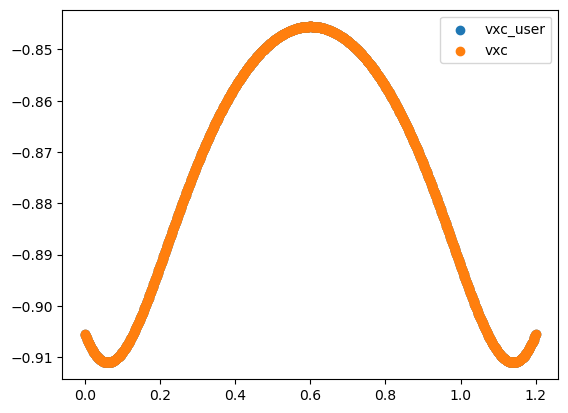

In [46]:
#user VXC and PYSCF VXC
plt.scatter(r, vxc_user, label='vxc_user')
plt.scatter(r, vxc, label='vxc')
plt.legend()

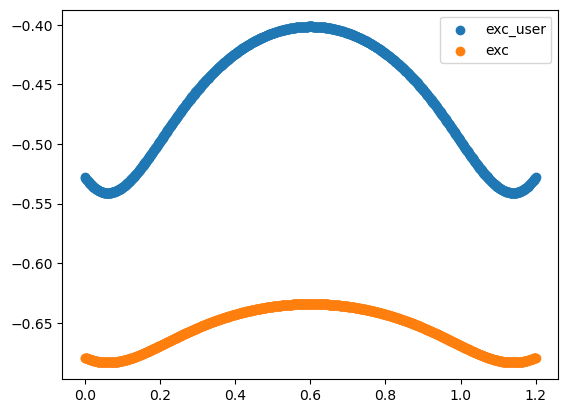

In [47]:
#user EXC and PYSCF EXC
plt.scatter(r, exc_user, label='exc_user')
plt.scatter(r, excd, label='exc')
plt.legend()

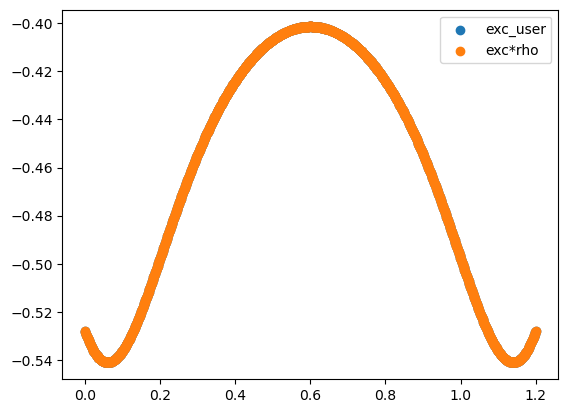

In [48]:
#PYSCF EXC*rho and user EXC
plt.scatter(r, exc_user, label='exc_user')
plt.scatter(r, excd*rho, label='exc*rho')
plt.legend()

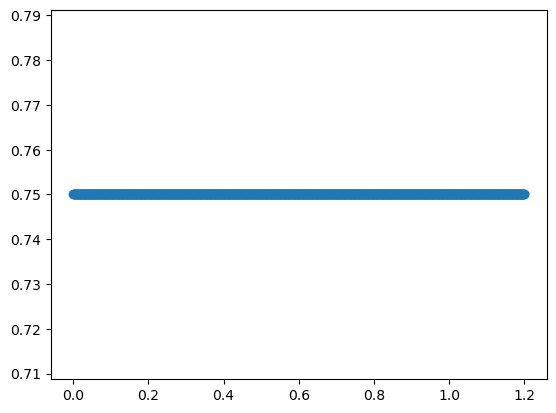

In [49]:
plt.scatter(r, exc_user/vxc_user/rho)

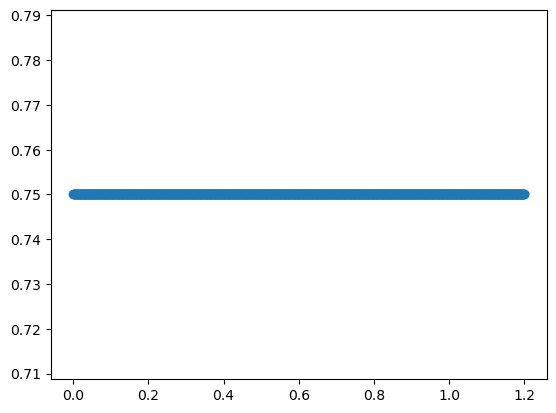

In [50]:
plt.scatter(r, excd/vxc)

In [51]:
# Use regular grid to calculate energies
mol = mf.mol
coords = mf.grids.coords
weights = mf.grids.weights
reg_grid = numint.eval_ao(mol, coords)

In [52]:
rho_reg = numint.eval_rho(mol, reg_grid, dm, xctype='LDA')
excd_reg, vxcs_reg  = dft.libxc.eval_xc('LDA,VWN', rho_reg)[:2]
print(np.einsum('i,i,i->', excd_reg, rho_reg, weights))
print(np.einsum('i,i,i->', vxcs_reg[0], rho_reg, weights))

-0.6843546298633653
-0.8943012814962873


In [53]:
excd_reg_user, vxcs_reg_user  = eval_xc(rho_reg)[:2]
np.einsum('i,i,i->', excd_reg_user, rho_reg, weights)

-0.0776195151272708

In [54]:
nelec, exc2, vxc2 = dft.numint.nr_vxc(mol, mf.grids, 'lda,vwn', dm)
print(exc2)

-0.6843546298633597
